#### Name : Shubham Agrawal
#### Roll No. : 2019201085


In [ ]:
!pip install aicrowd-cli
API_KEY = "fd1aed7204268f0bae2780fb808a4063" #Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY
!rm -rf data
!mkdir data
%cd data/
!aicrowd dataset download --challenge chunin-exams-food-track-cv-2021
!ls
!unzip train_images.zip
!unzip test_images.zip

In [ ]:
# !ls
!ls train_images/ | wc -l
!ls test_images/ | wc -l

test.csv     test_images.zip  train_images
test_images  train.csv	      train_images.zip
9323
484


### Import required modules

In [ ]:
## Start coding
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os, string, sys, re
import time
import copy
from tqdm import tqdm
import timeit

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

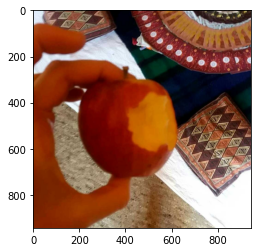

In [ ]:
img = cv2.imread('train_images/00061604fc.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## 1. Creating dataset class and loading data

In [ ]:
def load_image(image_path):
  img = cv2.imread(image_path)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (260, 260))
  return img

def show_image(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)

def get_labels_mapping(path, attribute_name):
  metadata = pd.read_csv(path)
  labels = metadata[attribute_name].unique()
  labels_mapping = {}
  #print(len(labels))
  for i in range(len(labels)):
    labels_mapping[labels[i]] = i
  return labels_mapping

class MyDataset(Dataset):
  def __init__(self, path, csv_file, istrain=True):
    self.images = []
    self.labels = []
    self.istrain = istrain
    # images_name = os.listdir(path)
    metadata = pd.read_csv(csv_file)
    
    for img in tqdm(metadata['ImageId']):
      self.images.append(path + '/' + img)
    

    if(self.istrain):
      self.labels_mapping = get_labels_mapping(csv_file, 'ClassName')
      for lab in tqdm(metadata['ClassName']):
        self.labels.append(lab)
     
  def __getitem__(self, index):
    image1 = load_image(self.images[index])
    if(self.istrain):
      label1 = self.labels[index]
      # print(label1, self.labels_mapping[label1])
      return transforms.ToTensor()(image1), torch.tensor(self.labels_mapping[label1])
    return transforms.ToTensor()(image1)
    
  def __len__(self):
    return len(self.images)

In [ ]:
dataset = MyDataset('train_images/', 'train.csv', True)

100%|██████████| 9323/9323 [00:00<00:00, 1084671.61it/s]

61


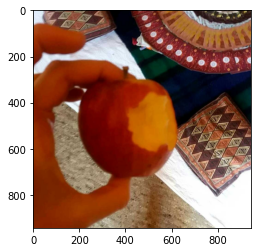

In [ ]:
image1, label1 = dataset[0]
show_image(image1.numpy())
# image1.shape

## 2. Data Split

In [ ]:
dataset_len = len(dataset)
batch_size = 10
split_ratio = 0.20

In [ ]:
indexes = np.arange(0, dataset_len)
np.random.shuffle(indexes)

In [ ]:
pivot = int(np.floor(split_ratio*dataset_len))
split = indexes[pivot:], indexes[:pivot]

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, sampler=SubsetRandomSampler(split[0]))
validation_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, sampler=SubsetRandomSampler(split[1]))
train_size = len(split[0])
validation_size = len(split[1])
print(train_size)
print(validation_size)

1600
400


In [ ]:
i, l = iter(train_dataloader).next()
print(l)

tensor([45, 17, 29, 17,  0,  0, 33, 17, 22, 52])


## 3. Using Pretrained Model

### I have used two pretrained models one is resnet50 and other is resnet101

## I got the best validation accuracy with resnet 101 with batch size = 10 and learning rate = 0.005

### This training code is taken from official website of pytorch and I have modified it according to my convience

In [1]:
def train(model, epochs, criterion, optimizer):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = []
    validation_loss = []
    # print("Trainin Model : ")
    for epoch in tqdm(range(epochs)):
        print('Epoch: ', epoch+1)
        print('-'*12)
        for phase in ['train', 'val']:
            dataloader = None
            datasize = None
            if phase == 'train':
                model.train() 
                dataloader = train_dataloader
                datasize = train_size
            else:
                model.eval()
                dataloader = validation_dataloader
                datasize = validation_size

            running_loss = 0.0
            running_corrects = 0
            print('Iterating through data...')
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / datasize
            epoch_acc = running_corrects.double() / datasize
            if (phase == 'train'):
              train_loss.append(epoch_loss)
            else:
              validation_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)  
    print("Done")
    return model, train_loss, validation_loss

### 1. Resnet50

In [ ]:
labels_count = 61
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, labels_count)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model = train(model, 10, criterion, optimizer)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 0/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 2.4866 Acc: 0.3748
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.7531 Acc: 0.5124

Epoch 1/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 1.6337 Acc: 0.5374
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.7725 Acc: 0.5313

Epoch 2/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 1.2731 Acc: 0.6243
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.6702 Acc: 0.5541

Epoch 3/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.9781 Acc: 0.7073
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.7010 Acc: 0.5661

Epoch 4/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.7273 Acc: 0.7816
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.9230 Acc: 0.5399

Epoch 5/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.5286 Acc: 0.8441
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 2.0257 Acc: 0.5356

Epoch 6/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.2577 Acc: 0.9384
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.7683 Acc: 0.5790

Epoch 7/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.1835 Acc: 0.9671
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.7702 Acc: 0.5781

Epoch 8/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.1510 Acc: 0.9764
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.7805 Acc: 0.5820

Epoch 9/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.1353 Acc: 0.9808
Iterating through data...


100%|██████████| 233/233 [00:16<00:00, 13.97it/s]

val Loss: 1.7768 Acc: 0.5841

Training complete in 18m 53s
Best val Acc: 0.584120


In [ ]:
model.eval()
correct = 0
total = 0
res = []
with torch.no_grad():  
  for images, labels in validation_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    res.extend(list(predicted))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy : ', 100*correct/total)

Accuracy :  58.412017167381975


### 2. Resnet101

In [ ]:
labels_count = 61
model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, labels_count)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [ ]:
model = train(model, 10, criterion, optimizer)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 0/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 2.3956 Acc: 0.3871
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.8192 Acc: 0.4957

Epoch 1/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 1.5542 Acc: 0.5594
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.6139 Acc: 0.5446

Epoch 2/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 1.1635 Acc: 0.6582
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.7240 Acc: 0.5562

Epoch 3/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.8700 Acc: 0.7380
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.7037 Acc: 0.5545

Epoch 4/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.6063 Acc: 0.8205
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.9338 Acc: 0.5519

Epoch 5/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.4066 Acc: 0.8807
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 2.0498 Acc: 0.5476

Epoch 6/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.1922 Acc: 0.9541
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.8225 Acc: 0.5811

Epoch 7/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.1323 Acc: 0.9751
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.7613 Acc: 0.5888

Epoch 8/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.1063 Acc: 0.9861
Iterating through data...


  0%|          | 0/700 [00:00<?, ?it/s]

val Loss: 1.8339 Acc: 0.5833

Epoch 9/9
----------
Iterating through data...


  0%|          | 0/233 [00:00<?, ?it/s]

train Loss: 0.0853 Acc: 0.9890
Iterating through data...


100%|██████████| 233/233 [00:20<00:00, 11.55it/s]

val Loss: 1.8484 Acc: 0.5815

Training complete in 28m 53s
Best val Acc: 0.588841


### Batch Size = 10 and learning rate = 0.005

In [ ]:
model.eval()
correct = 0
total = 0
res = []
with torch.no_grad():  
  for images, labels in validation_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    res.extend(list(predicted))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy : ', 100*correct/total)

Accuracy :  58.88412017167382


### BatchSize = 20 and leraning rate = 0.005

In [ ]:
model = train(model, 10, criterion, optimizer)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 0/9
----------
Iterating through data...


  0%|          | 0/34 [00:00<?, ?it/s]

train Loss: 2.2944 Acc: 0.4075
Iterating through data...


  0%|          | 0/153 [00:00<?, ?it/s]

val Loss: 1.9039 Acc: 0.4785

Epoch 1/9
----------
Iterating through data...


  0%|          | 0/34 [00:00<?, ?it/s]

train Loss: 1.4329 Acc: 0.5868
Iterating through data...


  0%|          | 0/153 [00:00<?, ?it/s]

val Loss: 1.9054 Acc: 0.5030

Epoch 2/9
----------
Iterating through data...


  0%|          | 0/34 [00:00<?, ?it/s]

train Loss: 0.7625 Acc: 0.7657
Iterating through data...


  0%|          | 0/153 [00:00<?, ?it/s]

val Loss: 1.4698 Acc: 0.5745

Epoch 3/9
----------
Iterating through data...


  0%|          | 0/34 [00:00<?, ?it/s]

train Loss: 0.4263 Acc: 0.8747
Iterating through data...


  0%|          | 0/153 [00:00<?, ?it/s]

val Loss: 1.5572 Acc: 0.5775

Epoch 4/9
----------
Iterating through data...


  0%|          | 0/34 [00:00<?, ?it/s]

train Loss: 0.2261 Acc: 0.9448
Iterating through data...


  0%|          | 0/153 [00:00<?, ?it/s]

val Loss: 1.6484 Acc: 0.5822

Epoch 5/9
----------
Iterating through data...


  0%|          | 0/34 [00:00<?, ?it/s]

train Loss: 0.1050 Acc: 0.9860
Iterating through data...


  0%|          | 0/153 [00:00<?, ?it/s]

val Loss: 1.6201 Acc: 0.5745

Epoch 6/9
----------
Iterating through data...


  0%|          | 0/34 [00:00<?, ?it/s]

train Loss: 0.0706 Acc: 0.9942
Iterating through data...


  0%|          | 0/153 [00:00<?, ?it/s]

val Loss: 1.6561 Acc: 0.5828

Epoch 7/9
----------
Iterating through data...


  0%|          | 0/34 [00:00<?, ?it/s]

train Loss: 0.0542 Acc: 0.9983
Iterating through data...


  0%|          | 0/153 [00:00<?, ?it/s]

val Loss: 1.6753 Acc: 0.5864

Epoch 8/9
----------
Iterating through data...


  0%|          | 0/34 [00:00<?, ?it/s]

train Loss: 0.0444 Acc: 0.9992
Iterating through data...


  0%|          | 0/153 [00:00<?, ?it/s]

val Loss: 1.6880 Acc: 0.5805

Epoch 9/9
----------
Iterating through data...


  0%|          | 0/34 [00:00<?, ?it/s]

train Loss: 0.0423 Acc: 0.9992
Iterating through data...


100%|██████████| 34/34 [00:13<00:00,  2.43it/s]

val Loss: 1.6925 Acc: 0.5816

Training complete in 29m 5s
Best val Acc: 0.586412


### Batch Size = 10 and  learning rate = 0.010

In [ ]:
model.eval()
correct = 0
total = 0
res = []
with torch.no_grad():  
  for images, labels in validation_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    res.extend(list(predicted))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy : ', 100*correct/total)

Accuracy :  58.87961859356377


### Batch Size = 50 and  learning rate = 0.010

In [ ]:
model.eval()
correct = 0
total = 0
res = []
with torch.no_grad():  
  for images, labels in validation_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    res.extend(list(predicted))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy : ', 100*correct/total)

Accuracy :  56.7342073897497


### 4. Predicting the results for Test Dataset

In [ ]:
test_dataset = MyDataset('test_images/', 'test.csv', False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

100%|██████████| 484/484 [00:00<00:00, 1067881.71it/s]


In [ ]:
model.eval()
predictions = []
with torch.no_grad():
    for image in test_dataloader:
        data = image.squeeze(0).to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
          predictions.append(i)
print(predictions)
labels_mapping = get_labels_mapping('train.csv', 'ClassName')
inv_mapping = {}
for k, v in labels_mapping.items():
  inv_mapping[v] = k
predicted_labels = []
for i in predictions:
  predicted_labels.append(inv_mapping[i])
print(predicted_labels)

[0, 0, 46, 27, 25, 46, 24, 25, 0, 20, 46, 0, 21, 6, 46, 36, 7, 15, 15, 3, 25, 4, 35, 25, 0, 0, 32, 31, 13, 49, 2, 33, 16, 0, 27, 6, 46, 0, 5, 5, 1, 49, 46, 47, 46, 6, 48, 42, 11, 4, 48, 35, 46, 26, 19, 18, 16, 49, 3, 9, 3, 16, 5, 0, 19, 46, 29, 2, 16, 0, 39, 58, 3, 10, 35, 4, 35, 49, 16, 7, 11, 35, 4, 4, 50, 29, 4, 3, 3, 26, 7, 46, 19, 16, 12, 43, 0, 32, 42, 0, 32, 31, 46, 27, 25, 0, 6, 48, 3, 45, 5, 9, 6, 50, 49, 14, 14, 29, 25, 19, 12, 21, 50, 35, 46, 14, 6, 42, 33, 36, 0, 25, 16, 30, 44, 34, 19, 28, 19, 21, 29, 29, 12, 12, 20, 46, 32, 25, 55, 21, 19, 35, 35, 15, 10, 25, 4, 32, 40, 37, 3, 26, 44, 16, 37, 42, 4, 39, 5, 5, 56, 42, 44, 0, 51, 39, 25, 42, 35, 35, 16, 2, 6, 42, 14, 6, 12, 6, 0, 29, 46, 33, 19, 46, 20, 38, 15, 15, 35, 32, 51, 20, 0, 6, 3, 0, 22, 5, 56, 56, 37, 38, 2, 6, 21, 0, 29, 5, 6, 15, 6, 29, 3, 35, 33, 13, 5, 5, 49, 0, 6, 3, 16, 46, 25, 46, 6, 44, 19, 19, 35, 35, 27, 33, 7, 0, 46, 21, 0, 20, 46, 46, 27, 17, 19, 19, 32, 42, 17, 12, 15, 46, 55, 21, 4, 35, 35, 30, 4, 30

In [ ]:
df = pd.DataFrame(predicted_labels,columns=['ClassName'])
df.to_csv('submission.csv',index=False)
from google.colab import files
files.download('submission.csv')